In [2]:
import os
import cv2
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

c:\Users\nikis\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\nikis\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

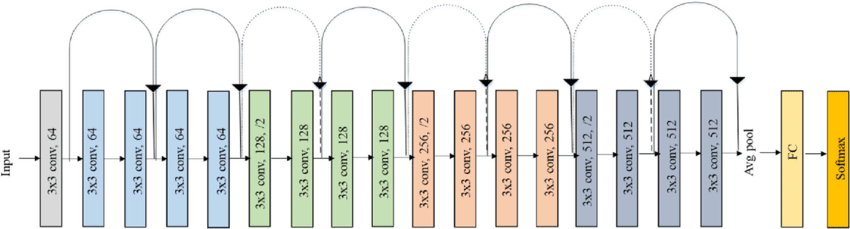

In [4]:

#++++++++++++++++++++++++++++++++++++++++++++=======================================++++++++++++++++++++++++++++++++++++++++++++++
#                                                        NETWORK MODEL: ResNet18 (V16)
#++++++++++++++++++++++++++++++++++++++++++++=======================================++++++++++++++++++++++++++++++++++++++++++++++

"""
Pseudo ResNet 18 (16 3x3 convolutions + 1 7x7 IN conv + 1 FC layer)
conv 7x7 64 channels
bn
maxpool

1
resblock 1 64 x2
resblock 1 64 x2 conv
2
resblock 2 128 x2
resblock 2 128 x2
3
resblock 3 256 x2
resblock 3 256 x2
4
resblock 4 512 x2
resblock 4 512 x2

conv 1x1 1024
avgpool
flatten

classifier
1024 x num classes

"""

class ResidualBlock(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels, activation=nn.ReLU, first_stride=1, skip=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=first_stride, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.activ = activation()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.skip = skip
        self.upchannel = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        init = x
        x = self.conv1(x)
        x = self.bnorm1(x)
        x = self.activ(x)

        x = self.conv2(x)
        x = self.bnorm2(x)

        if self.skip:
            if init.shape != x.shape:
                init = self.upchannel(init)  # преобразование размерности init при необходимости
            x += init
        else:
            x += self.upchannel(init)

        x = self.activ(x)
        return x

class ResNetV16(nn.Module):
    def __init__(self, num_classes, in_channels=3, activation=nn.ReLU):
        super(ResNetV16, self).__init__()
        self.activ = activation()
        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            self.activ,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.step1 = nn.Sequential(
            ResidualBlock(3, 64, 64, first_stride=2),
            ResidualBlock(3, 64, 64)
        )
        self.step2 = nn.Sequential(
            ResidualBlock(3, 64, 128, first_stride=2, skip=False),
            ResidualBlock(3, 128, 128)
        )
        self.step3 = nn.Sequential(
            ResidualBlock(3, 128, 256, first_stride=2, skip=False),
            ResidualBlock(3, 256, 256)
        )
        self.step4 = nn.Sequential(
            ResidualBlock(3, 256, 512, first_stride=2, skip=False),
            ResidualBlock(3, 512, 512)
        )

        self.avgpull = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.first_conv(x)
        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.avgpull(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

AdaBound здесь:
*   https://pytorch-optimizer.readthedocs.io/en/latest/index.html
*   https://pytorch-optimizer.readthedocs.io/en/latest/api.html#adabound

In [5]:

class CarDataset(Dataset):
    def __init__(self, filenames, labels, folder_path, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.filenames[idx])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        
        # Преобразование в PIL Image
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
# Загрузка данных из .mat файлов
train_data_ans = scipy.io.loadmat('stanford-cars/annotations/cars_train_annos.mat')
test_data_ans = scipy.io.loadmat('stanford-cars/annotations/cars_test_annos_withlabels_eval.mat')
class_names_data = scipy.io.loadmat('stanford-cars/annotations/cars_meta.mat')

# Загрузка имен файлов
train_filenames = [str(fn[0]) for fn in train_data_ans['annotations']['fname'][0]]
test_filenames = [str(fn[0]) for fn in test_data_ans['annotations']['fname'][0]]

# Загрузка классов
train_classes = [int(cls[0][0]) for cls in train_data_ans['annotations']['class'][0]]
test_classes = [int(cls[0][0]) for cls in test_data_ans['annotations']['class'][0]]

# Подготовка данных для PyTorch
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = CarDataset(train_filenames, train_classes, 'stanford-cars/cars_train', transform=transform_train)
test_dataset = CarDataset(test_filenames, test_classes, 'stanford-cars/cars_test', transform=transform_test)

In [7]:
len(train_dataset)

8144

In [8]:
class_names = class_names_data['class_names'][0]
num_classes = 197

print(f"Количество классов: {num_classes}")
print("Список классов:")
for class_name in class_names:
    print(class_name[0])

Количество классов: 197
Список классов:
AM General Hummer SUV 2000
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura Integra Type R 2001
Acura ZDX Hatchback 2012
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012
Aston Martin Virage Coupe 2012
Audi RS 4 Convertible 2008
Audi A5 Coupe 2012
Audi TTS Coupe 2012
Audi R8 Coupe 2012
Audi V8 Sedan 1994
Audi 100 Sedan 1994
Audi 100 Wagon 1994
Audi TT Hatchback 2011
Audi S6 Sedan 2011
Audi S5 Convertible 2012
Audi S5 Coupe 2012
Audi S4 Sedan 2012
Audi S4 Sedan 2007
Audi TT RS Coupe 2012
BMW ActiveHybrid 5 Sedan 2012
BMW 1 Series Convertible 2012
BMW 1 Series Coupe 2012
BMW 3 Series Sedan 2012
BMW 3 Series Wagon 2012
BMW 6 Series Convertible 2007
BMW X5 SUV 2007
BMW X6 SUV 2012
BMW M3 Coupe 2012
BMW M5 Sedan 2010
BMW M6 Convertible 2010
BMW X3 SUV 2012
BMW Z4 Convertible 2012
Bentley Continental Supersports Conv. Convertible 2012
Bentley Arnage Se

In [9]:
# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
len(train_loader)

64

In [12]:
import torch_optimizer as opt

# Определение модели, функции потерь и оптимизатора
model = ResNetV16(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimAdaBound = opt.AdaBound(model.parameters(), lr=1e-4)

In [13]:
# Функция обучения модели
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Прямой проход
        outputs = model(inputs)

        # Вычисление потерь
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

# Функция оценки модели
def evaluate(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return running_loss / len(test_loader), accuracy

In [14]:
# Обучение модели
num_epochs = 20
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    train_loss_AdaBound = train(model, train_loader, criterion, optimAdaBound, device)
    test_loss_AdaBound, test_accuracy = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss_AdaBound)
    test_losses.append(test_loss_AdaBound)
    print(f'Train Loss: {train_loss_AdaBound:.4f}, Test Loss: {test_loss_AdaBound:.4f}, Test Accuracy: {test_accuracy:.2%}')

Epoch [1/20]


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 63/63 [01:30<00:00,  1.44s/it]


Train Loss: 5.2412, Test Loss: 5.1397, Test Accuracy: 1.57%
Epoch [2/20]


100%|██████████| 63/63 [01:27<00:00,  1.39s/it]


Train Loss: 5.0133, Test Loss: 5.0242, Test Accuracy: 2.49%
Epoch [3/20]


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Train Loss: 4.8564, Test Loss: 4.9864, Test Accuracy: 2.67%
Epoch [4/20]


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Train Loss: 4.7069, Test Loss: 4.8631, Test Accuracy: 4.27%
Epoch [5/20]


100%|██████████| 63/63 [01:20<00:00,  1.27s/it]


Train Loss: 4.5475, Test Loss: 4.7499, Test Accuracy: 5.00%
Epoch [6/20]


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Train Loss: 4.3844, Test Loss: 4.6409, Test Accuracy: 6.01%
Epoch [7/20]


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Train Loss: 4.2013, Test Loss: 4.6155, Test Accuracy: 6.86%
Epoch [8/20]


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Train Loss: 4.0149, Test Loss: 4.5437, Test Accuracy: 7.39%
Epoch [9/20]


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Train Loss: 3.8293, Test Loss: 4.3894, Test Accuracy: 7.91%
Epoch [10/20]


100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Train Loss: 3.6440, Test Loss: 4.5738, Test Accuracy: 7.47%
Epoch [11/20]


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Train Loss: 3.4392, Test Loss: 4.3937, Test Accuracy: 9.35%
Epoch [12/20]


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Train Loss: 3.2394, Test Loss: 4.2650, Test Accuracy: 10.98%
Epoch [13/20]


100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Train Loss: 3.0478, Test Loss: 4.4495, Test Accuracy: 9.84%
Epoch [14/20]


100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


Train Loss: 2.8446, Test Loss: 4.1411, Test Accuracy: 12.40%
Epoch [15/20]


100%|██████████| 63/63 [01:22<00:00,  1.32s/it]


Train Loss: 2.6649, Test Loss: 4.0778, Test Accuracy: 14.25%
Epoch [16/20]


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Train Loss: 2.4578, Test Loss: 4.3895, Test Accuracy: 11.74%
Epoch [17/20]


100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


Train Loss: 2.2527, Test Loss: 4.1842, Test Accuracy: 14.70%
Epoch [18/20]


100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


Train Loss: 2.0726, Test Loss: 4.3877, Test Accuracy: 13.03%
Epoch [19/20]


100%|██████████| 63/63 [01:25<00:00,  1.36s/it]


Train Loss: 1.9048, Test Loss: 4.2422, Test Accuracy: 14.04%
Epoch [20/20]


100%|██████████| 63/63 [01:29<00:00,  1.41s/it]

Train Loss: 1.6878, Test Loss: 4.2101, Test Accuracy: 15.18%


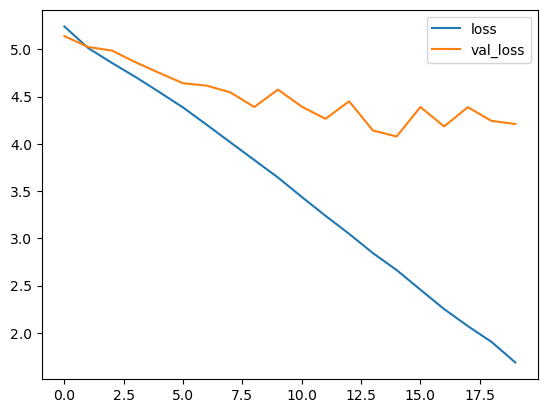

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(test_losses, label='val_loss')
plt.legend()
plt.show()

In [16]:
from torch.optim import Adam

# Обучение модели
num_epochs = 20
train_losses_adam, test_losses_adam = [], []
adam = Adam(model.parameters(), lr=1e-4)
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    train_loss_adam = train(model, train_loader, criterion, adam, device)
    test_loss_adam, test_accuracy_adam = evaluate(model, test_loader, criterion, device)
    train_losses_adam.append(train_loss_adam)
    test_losses_adam.append(test_loss_adam)
    print(f'Train Loss: {train_loss_adam:.4f}, Test Loss: {test_loss_adam:.4f}, Test Accuracy: {test_accuracy_adam:.2%}')

Epoch [1/20]


100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Train Loss: 1.3205, Test Loss: 3.7372, Test Accuracy: 20.15%
Epoch [2/20]


100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Train Loss: 1.0632, Test Loss: 3.6699, Test Accuracy: 21.19%
Epoch [3/20]


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Train Loss: 0.9189, Test Loss: 3.7423, Test Accuracy: 21.09%
Epoch [4/20]


100%|██████████| 63/63 [01:23<00:00,  1.33s/it]


Train Loss: 0.8025, Test Loss: 3.7207, Test Accuracy: 21.58%
Epoch [5/20]


100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


Train Loss: 0.7125, Test Loss: 3.7279, Test Accuracy: 21.86%
Epoch [6/20]


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Train Loss: 0.6203, Test Loss: 3.7450, Test Accuracy: 21.61%
Epoch [7/20]


100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


Train Loss: 0.5358, Test Loss: 3.7819, Test Accuracy: 21.04%
Epoch [8/20]


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Train Loss: 0.4741, Test Loss: 3.7039, Test Accuracy: 22.20%
Epoch [9/20]


100%|██████████| 63/63 [01:23<00:00,  1.33s/it]


Train Loss: 0.4207, Test Loss: 3.7377, Test Accuracy: 22.65%
Epoch [10/20]


100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


Train Loss: 0.3447, Test Loss: 3.7375, Test Accuracy: 22.50%
Epoch [11/20]


100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Train Loss: 0.3112, Test Loss: 3.7893, Test Accuracy: 22.55%
Epoch [12/20]


100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


Train Loss: 0.2789, Test Loss: 3.8332, Test Accuracy: 22.62%
Epoch [13/20]


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Train Loss: 0.2484, Test Loss: 3.7801, Test Accuracy: 22.88%
Epoch [14/20]


100%|██████████| 63/63 [01:23<00:00,  1.33s/it]


Train Loss: 0.2174, Test Loss: 3.8309, Test Accuracy: 22.71%
Epoch [15/20]


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Train Loss: 0.1993, Test Loss: 3.8211, Test Accuracy: 22.96%
Epoch [16/20]


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Train Loss: 0.1790, Test Loss: 3.8039, Test Accuracy: 23.74%
Epoch [17/20]


100%|██████████| 63/63 [01:23<00:00,  1.33s/it]


Train Loss: 0.1563, Test Loss: 3.8543, Test Accuracy: 22.88%
Epoch [18/20]


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


Train Loss: 0.1516, Test Loss: 3.8184, Test Accuracy: 23.67%
Epoch [19/20]


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


Train Loss: 0.1378, Test Loss: 3.8767, Test Accuracy: 23.29%
Epoch [20/20]


100%|██████████| 63/63 [01:14<00:00,  1.18s/it]

Train Loss: 0.1277, Test Loss: 3.8616, Test Accuracy: 23.23%


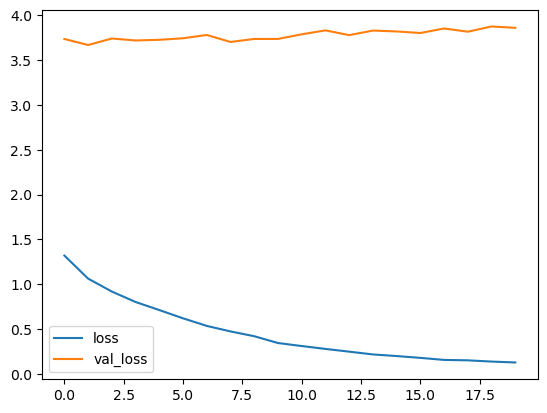

In [17]:
plt.plot(train_losses_adam, label='loss')
plt.plot(test_losses_adam, label='val_loss')
plt.legend()
plt.show()